In [1]:
import sys
sys.path.append('..')

from common.utility import show_implementation
from module.utility import show_images
import numpy as np
from PIL import Image

In [2]:
rose_image = np.array(Image.open('images/rose.jpg').resize((288, 216)).convert('L'))
words_image = np.array(Image.open('images/words.jpg').resize((288, 216)).convert('L'))

# Gradients and Edges
## Motivation

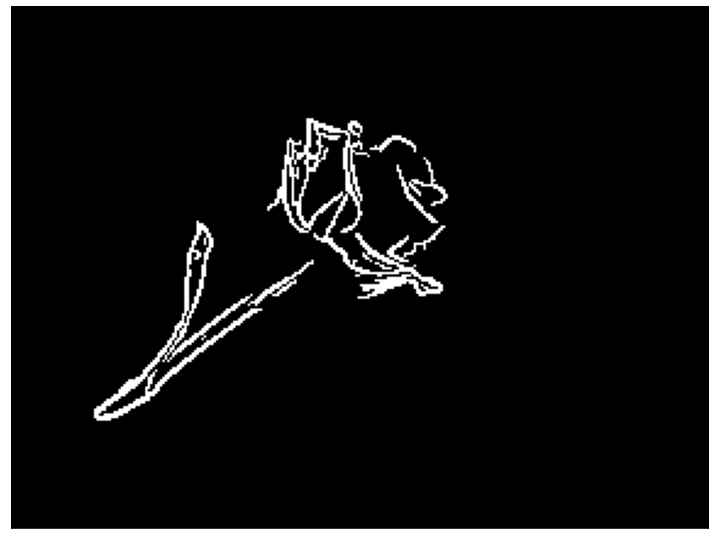

In [3]:
from module.canny_edge import canny_edge

outline = canny_edge(rose_image, 25, 18)
show_images([(outline, "", True)])

Consider the above images.
Despite it being only the outline of the subject, we can clearly recognize it as a flower of some kind.
Thus, this cues us to realize that edges carries a significant portion of information in an image.

## Identification
How should we identify edges?

A logical assumption is that edges corresponds to regions in the image where there is a sharp discontinuity in the image.
For example, in the below image, we compute the intensity across the (red) horizontal scan line.
Notice that the edge of subject corresponds to a large dip/rise in intensity.
Thus, this prompts us to look at the 1st derivative of the intensity across the scan line.
From here, we can see that the edges now corresponds to regions where the derivative of the intensity is of large magnitude. 

In [4]:
import matplotlib.pyplot as plt

def show_scanline(image, second_order=False):
    height, width = image.shape
    y = height // 3

    fig, (ax1, ax2, *dxs) = plt.subplots(3 if not second_order else 4, sharex=True,figsize=(5, 10))

    ax1.imshow(image, cmap='gray')

    scan_line = image[y]
    derivatives = np.append(np.diff(scan_line.astype(np.float64)), 0)

    ax1.set_title('Image')
    ax2.set_title('Scan Line Intensity')
    dxs[0].set_title('Scan Line Derivative')
    
    ax1.set_aspect('auto')
    ax2.set_aspect('auto')
    dxs[0].set_aspect('auto')
    
    if second_order:
        dxs[1].set_title('Scan Line 2nd Derivative')
        dxs[1].set_aspect('auto')

    ax1.plot((0, width), (y, y))
    ax2.plot(range(width), scan_line)
    dxs[0].plot(range(len(derivatives)), derivatives);
    
    if second_order:
        derivatives = np.append(np.diff(scan_line.astype(np.float64), n=2), 0)
        dxs[1].plot(range(len(derivatives)), derivatives);


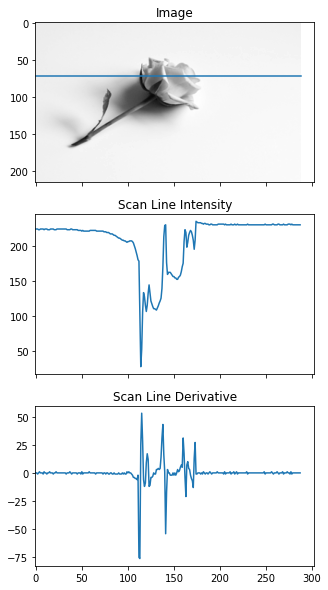

In [5]:
show_scanline(rose_image)

In order words, if we view the image as a 3D surface (as per below), then we are looking at regions where there are sudden change in elevation.

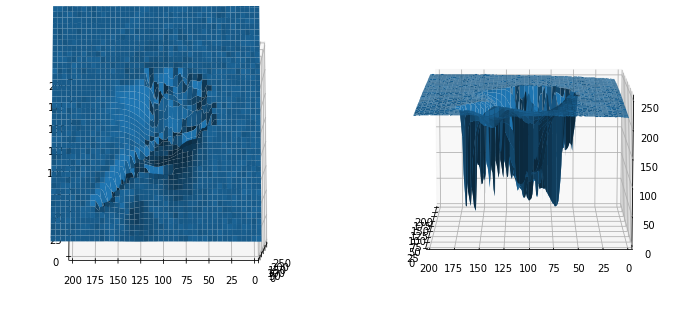

In [6]:
ys, xs = rose_image.shape
xs, ys = range(xs), range(ys)
xs, ys = np.meshgrid(xs, ys)
zs = rose_image

fig = plt.figure(figsize=(12,24))
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.elev = 80
ax.azim = 180
ax.set_xlim3d(0, 200)
ax.set_ylim3d(0, 200)
ax.set_zlim3d(0, 255)
ax.plot_surface(xs, ys, zs);

ax2 = fig.add_subplot(1, 2, 2, projection='3d')
ax2.elev = 10
ax2.azim = 180
ax2.set_xlim3d(0, 200)
ax2.set_ylim3d(0, 200)
ax2.set_zlim3d(0, 255)
ax2.plot_surface(xs, ys, zs);

## <span id="image-gradient"/> Image Gradient
The gradient is a vector that points in the direction of the largest change in intensity.
Thus, the gradient of image $f$, defined as $\nabla f = \left[ \frac{\partial f} {\partial x}, \frac{\partial f} {\partial y} \right]$.

The **gradient direction** is defined simply as
$$
\theta = \arctan \left(\frac{\partial f} {\partial y} / \frac{\partial f} {\partial x}\right)
$$

, and the **gradient magnitude** is defined simply as
$$
||\nabla f|| = \sqrt {\left(\frac{\partial f} {\partial y}\right)^2 + \left(\frac{\partial f} {\partial x}\right)^2}
$$
by geometry

## Discrete Gradient
However, notice that the above applies for continuous 2D functions.
We can extend this to discrete functions (like in case of images), by considering the differences between pixels.

Recall that in calculus, we can define the derivative using forward difference per below
$$
f'(x) = \lim _{h \rightarrow \infty} \frac{f(x+h) -f(x)}{h}
$$

However, since we are interested in the gradient in both directions for a selected pixel, we can use central difference instead:
$$
f'(x) = \lim _{h \rightarrow \infty} \frac{f(x+0.5h) -f(x-0.5h)}{h}
$$

Finally, we extend this to the discrete case by removing the limit and setting $h=2$ to obtain some form of discrete gradient, thus yielding
$$
f'(x) = \frac{f(x+1) -f(x-1)}{2}
$$

### Filter

A big thing to notice is that we can process the above calculation as simply a filtering operation (remember, we mean convolution conventionally), using the below 1D kernel.

$$
f = \begin{pmatrix}
\frac{1}{2} & 0 & -\frac{1}{2} 
\end{pmatrix}
$$

(Note that the first value in the matrix is possible and the last is negative, because the first value corresponds to the "following pixel" while the last value corresponds to the "previous pixel" as convolution flips the kernel before correlating)

Since we are only interested in the relative magnitude of the derivatives when detecting edges, we can drop the $\frac{1}{2}$ factor to improve performance, giving us the following kernel:

$$
f = \begin{pmatrix}
1 & 0 & -1
\end{pmatrix}
$$

#### Types of Filters
##### Prewitt Filter
Remember that we prefer to work with square filters if possible?
We can extend the previous kernel into a square kernel, simply by extending it vertically.
Thus, we get
$$
f = \begin{pmatrix}
1 & 0 & -1 \\
1 & 0 & -1 \\
1 & 0 & -1 \\
\end{pmatrix}
$$

This is also known as the **Prewitt filter**.

Of course, this only detects vertical edges, to detect horizontal ones, we simply rotate the kernel.

$$
f = \begin{pmatrix}
1 & 1 &  1 \\
0 & 0 &  0 \\
-1 & -1 & -1 \\
\end{pmatrix}
$$

(Note that filters that detects horizontal edges are detecting for the gradients in the vertical direction, and vice versa)

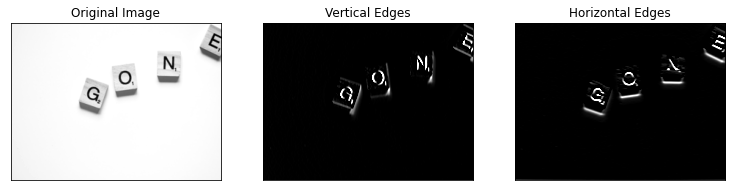

In [7]:
from module.convolve import convolve
from module.kernel import prewitt
from module.kernel import Orientation

show_images([(words_image, "Original Image"), 
             (convolve(words_image, prewitt(Orientation.horizontal), clip=False), "Vertical Edges"),
             (convolve(words_image, prewitt(Orientation.vertical), clip=False), "Horizontal Edges")])

Notice that around the 'O', the horizontal filter detects the horizontal arcs in the 'O', while the vertical filter detects the vertical arcs.

##### Sobel Filter
Even though extending into the Prewitt filter is intuitive, a more commonly used filter is the Sobel filter

$$
f = \begin{pmatrix}
1 & 0 & -1 \\
2 & 0 & -2 \\
1 & 0 & -1 \\
\end{pmatrix}
$$

Notice that this filter can be broken down as follows

$$
f = \begin{pmatrix}
1 & 1 &  1 \\
0 & 0 &  0 \\
-1 & -1 & -1 \\
\end{pmatrix}
= 
\begin{pmatrix}
1 \\ 2 \\ 1
\end{pmatrix}
*
\begin{pmatrix}
1 & 0 & -1
\end{pmatrix}
$$

Notice that 
$
\begin{pmatrix}
1 \\ 2 \\ 1
\end{pmatrix}
$
is just a blurring filter which has higher weight for the center pixel.
Thus, it is equivalent to blurring before detecting the edges.

Equivalently, we can see that the Prewitt filter uses a simply box filter before detecting the edges.

Notice that we exploited the associative property of convolution.
Rather than applying two 1D filters on the image, we can convolve the 2 1D filters with each other first, and apply 1 2D filter on the image instead.
Because we are only processing on the image once (compared to twice in the former), there is performance benefits to doing so.

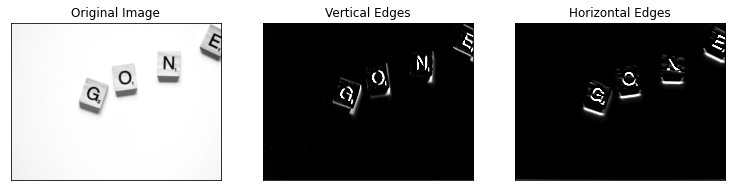

In [8]:
from module.kernel import sobel

show_images([(words_image, "Original Image"), 
             (convolve(words_image, sobel(Orientation.horizontal), clip=False), "Vertical Edges"),
             (convolve(words_image, sobel(Orientation.vertical), clip=False), "Horizontal Edges")])

Note that due to how similar the two filters are, they give rather similar results.

For the other kernels, we will briefly run through them.
Explorations with the kernels are left as an exercise to the reader.

#### Scharr Filter
\begin{pmatrix}
3 & 0 & -3 \\
10 & 0 & -10 \\
3 & 0 & -3 \\
\end{pmatrix}

#### Roberts Filter
\begin{pmatrix}
0 & 1 \\
-1 & 0
\end{pmatrix}

## Computing Image Gradient
To bring it all back, recall that image gradient [consists of both a magnitude component and a direction component](#image-gradient).

Hence, to compute the image gradient is simply:

1. Choose a gradient filter $S$
2. Convolve the image $f$ with the gradient filter to obtain the gradient components in both directions
$$
\frac{\partial f}{\partial x} = S_x * f \quad 
\frac{\partial f}{\partial y} = S_y * f \quad
\nabla f = \left(\frac{\partial f}{\partial x}, \frac{\partial f}{\partial y}\right)
$$
3. Compute the gradient magnitude $||\nabla f||$ and orientation $\theta$
$$
\theta = \arctan\left(\frac{\partial f}{\partial y}/ \frac{\partial f}{\partial x}\right) \quad
||\nabla f|| = \sqrt{\left(\frac{\partial f}{\partial x}\right)^2 + \left(\frac{\partial f}{\partial y}\right)^2}
$$

In [9]:
from module.gradient import compute_gradient

show_implementation(compute_gradient)

def compute_gradient(image, gradient_kernel=prewitt):
    sx = convolve(image, gradient_kernel(Orientation.horizontal), clip=False, pad=False)
    sy = convolve(image, gradient_kernel(Orientation.vertical), clip=False, pad=False)

    mag = np.sqrt(sx**2 + sy**2)

    with np.errstate(divide='ignore', invalid='ignore'):
        theta = np.arctan2(sy, sx)
    return mag, theta


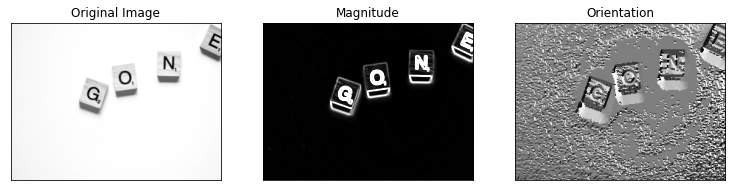

In [10]:
mag, theta = compute_gradient(words_image)

show_images([(words_image, "Original Image"), 
             (mag, "Magnitude"),
             (theta, "Orientation", True)])

Notice that our magnitude plot starts to identify the edges rather well.

The orientation plot looks rather messy because we are representing the angles as intensity values.
A more sensible way to look at the orientation is to look at is as a vector field, where the arrow points in the direction of the gradient.

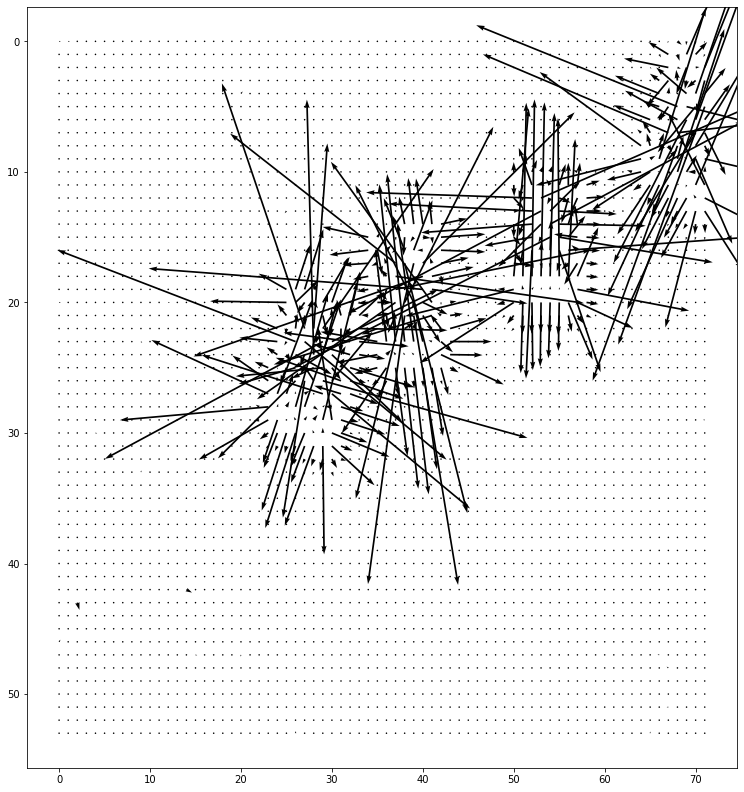

In [11]:
fig = plt.figure(figsize=(28,14))

def plot_theta(ax, mag, theta, interval):
    def polar_to_z(r,theta):
        return r * np.exp( 1j * theta )

    zs = polar_to_z(mag, theta)
    us = np.real(zs[::interval, ::interval])
    # In our computations, pi/2 corresponds to pointing to the bottom of the image (+ve y)
    # For quiver plot, pi/2 corresponds to pointing to the top of the image
    # Thus, we need to negate the y value to account for the different intepretations
    vs = -np.imag(zs[::interval, ::interval])

    ax.invert_yaxis()

    ax.quiver(us, vs);
    
ax = fig.add_subplot(1, 2, 2)
plot_theta(ax, mag, theta, interval=4)

As we can see, the background have small gradients, while the regions with the tiles have large gradients.

For comparison, we can look at the gradient of the following image of a smooth gradient.

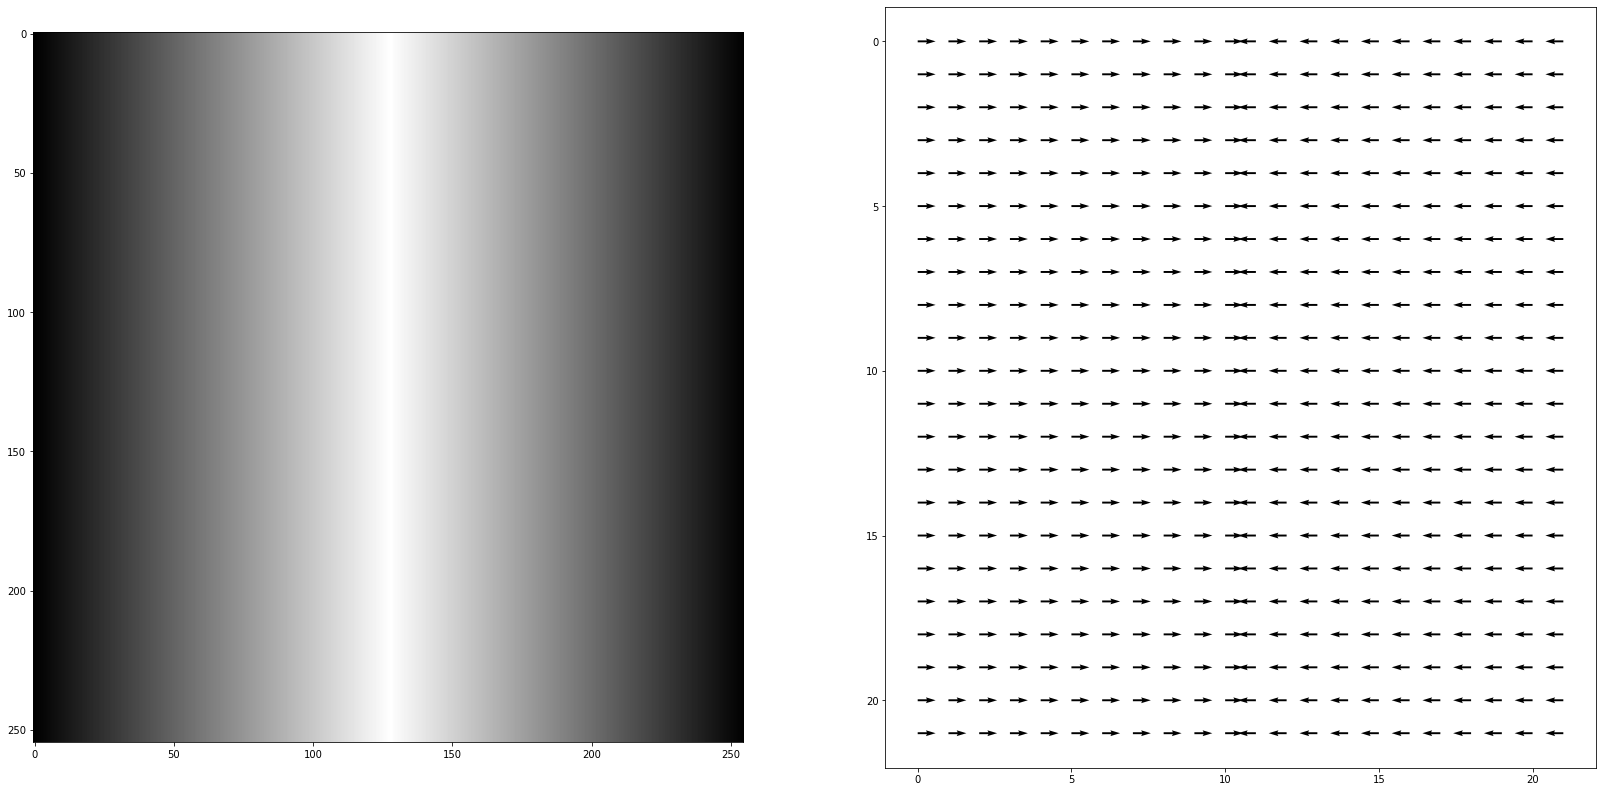

In [12]:
grad = np.where(np.arange(0, 255) <= 128, np.arange(0, 255), np.arange(255, 0, -1))
grad = np.tile(grad, (255, 1))

mag, theta = compute_gradient(grad)

fig = plt.figure(figsize=(28,14))
ax1 = fig.add_subplot(1, 2, 1)
ax1.imshow(grad, cmap='gray')
ax2 = fig.add_subplot(1, 2, 2)

plot_theta(ax2, mag, theta, interval=12)

As we can see, the magnitude and directions follows our intuitions.

## Effect of Noise

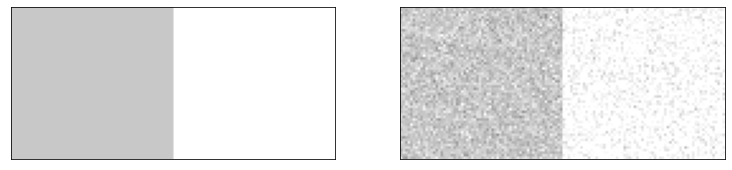

In [13]:
from module.add_noise import gaussian_noise
from module.kernel import gaussian_filter

image = np.tile(np.repeat([200, 255], 64), (60, 1))
noisy_image = gaussian_noise(image, sigma=18)

show_images([(image, ""), (noisy_image, "")])

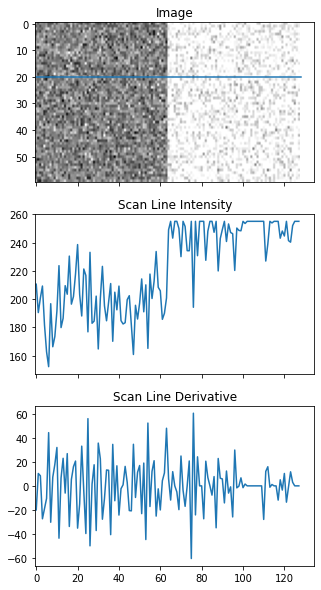

In [14]:
show_scanline(noisy_image)

Looking at its scanline, we notice that it is difficult to localize the edge due to the noise.
We can reason it as the following:

Suppose that we model the noise as a periodic signal in the image, thus as $\sin \omega x$, where $\omega$ is the frequency of the noise.

Let $f$ be the function of the intensity in our original image, then our noisy image is derived as 
$$
f(x) + \sin \omega x
$$

When we are finding the edge, we compute the derivative to be the value below:
$$
f'(x) + \frac{d \sin \omega x}{dx} = f'(x) + \omega \cos \omega x
$$

Since noise is modeled as high-frequency signals (*ie* large $\omega$), the derivative will have the noise amplified, thus greatly distorted by the noise.

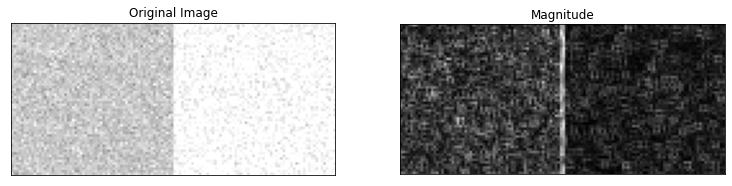

In [15]:
mag, _ = compute_gradient(noisy_image)
show_images([(noisy_image, "Original Image"), 
             (mag, "Magnitude", True)])

Indeed, it is difficult to find the extrema from the magnitude plot.

To remove the noise, we can apply blurring as described in [Filtering](./filtering.ipynb#noise-removal).

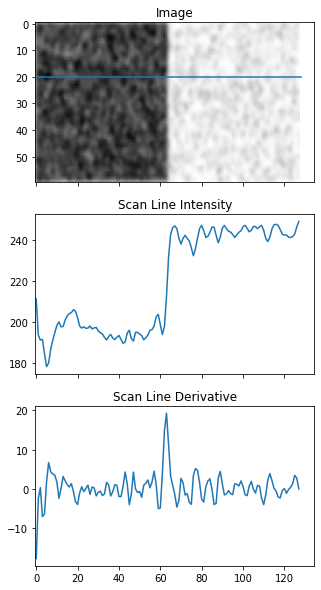

In [16]:
blurred_image = convolve(noisy_image, gaussian_filter(5))
show_scanline(blurred_image)

From above, we can see that we can now clearly identify the peak after filtering away the noise.
This brings us to the understanding that we should apply a blur before using our edge detection kernel.

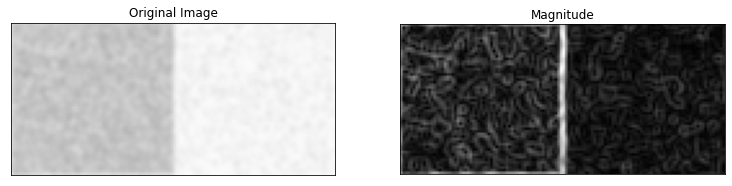

In [17]:
mag, _ = compute_gradient(blurred_image)
show_images([(blurred_image, "Original Image"), 
             (mag, "Magnitude", True)])

Notice the magnitude in the edge region is much higher than the noisy region.

### Drawback
Notice that after blurring, the edge region we detect has a "larger width".
This means that even though we can identify the region where the edge resides, we cannot localize it well.

## DoG and Laplace filter

### Differentiation property of convolution
With convolution, it also has another useful property.
The below holds:

$$
\frac{\partial } {\partial x} \left(h * f\right) = \left(\frac{\partial } {\partial x} h\right) * f
$$

### Derivative of Gaussian (DoG)
Thus, if we wish to have a kernel which gives us the magnitude, while accounting for noise, we can simply differentiate the Gaussian kernel to obtain our desired kernel.

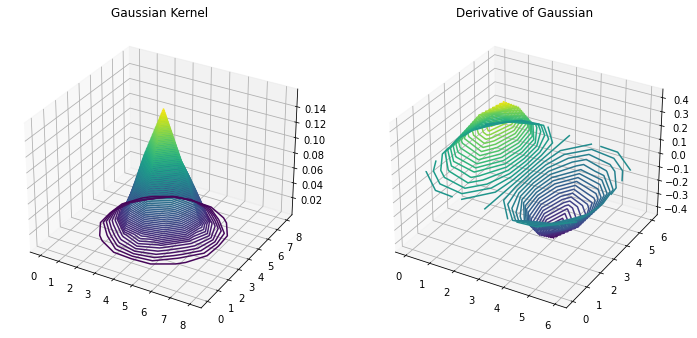

In [18]:
from module.kernel import gaussian_filter

SIZE = 9

xs, ys = range(SIZE), range(SIZE)
xs, ys = np.meshgrid(xs, ys)
zs = gaussian_filter(SIZE)
dog_kernel = convolve(zs, sobel(), pad=False, clip=False)

fig = plt.figure(figsize=(12,24))
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax1.contour3D(xs, ys, zs, 100, cmap='viridis');
ax1.set_title("Gaussian Kernel");

ax2 = fig.add_subplot(1, 2, 2, projection='3d')
ax2.distance = 25
ax2.contour3D(range(dog_kernel.shape[0]), range(dog_kernel.shape[0]), dog_kernel, 50, cmap='viridis');
ax2.set_title("Derivative of Gaussian");

The above is the Gaussian kernel and its derivative visualized as a 3D surface.

In [19]:
from module.kernel import dog

show_implementation(dog)

def dog(size, sigma=1, gradient_filter=prewitt, orientation=Orientation.horizontal):
    return convolve(gaussian_filter(size, sigma), gradient_filter(orientation), pad=False, clip=False)


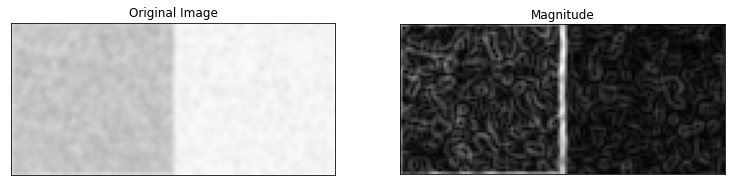

In [20]:
size = 5
make_dog = lambda orientation: dog(size, orientation=orientation)

mag, _ = compute_gradient(blurred_image, gradient_kernel=make_dog)
show_images([(blurred_image, "Original Image"), 
             (mag, "Magnitude", True)])

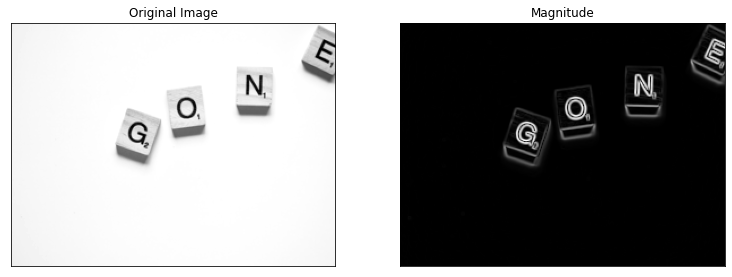

In [21]:
mag, _ = compute_gradient(words_image, gradient_kernel=make_dog)
show_images([(words_image, "Original Image"), 
             (mag, "Magnitude", True)])

Hence, we can approximate the gradient of the image in each direction with just one convolution operation on the image, which also accounts for noise.

### Laplace filter
We can also approximate the 2nd order derivative using finite differences.

$$
f''(x) = \lim _{h \rightarrow \infty} \frac{f(x+h) - 2 f(x) + f(x-h)}{h^2}
$$

Using similar concepts, we can derive the 1D Laplace filter (2nd order derivative filter) using the coefficient in the numerator:

$$
f = \begin{pmatrix}
1 & -2 & 1 
\end{pmatrix}
$$

Extending this, we obtain the following 2D Laplace filter

$$
f = \begin{pmatrix}
0 & 1 & 0 \\
1 & -4 & 1 \\
0 & 1 & 0 \\
\end{pmatrix}
$$


### Laplacian of Gaussian (LoG)
Thus, similarly, we can obtain the kernel which finds the 2nd order derivative of the image, while removing the noise.
We do so by simply convolving the Gaussian kernel with the 2D Laplacian kernel.

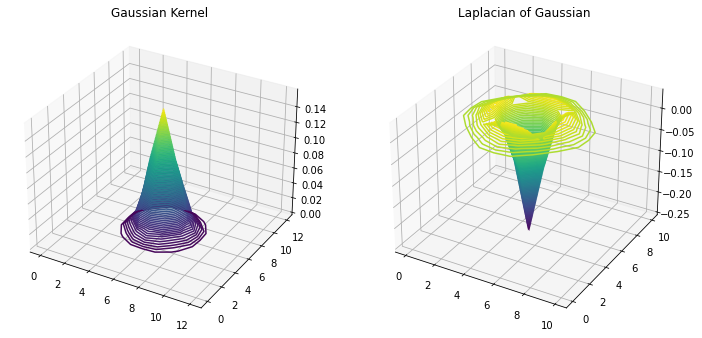

In [22]:
from module.kernel import laplace_filter

SIZE = 13

xs, ys = range(SIZE), range(SIZE)
xs, ys = np.meshgrid(xs, ys)
zs = gaussian_filter(SIZE)
log_kernel = convolve(zs, laplace_filter(), pad=False, clip=False)

fig = plt.figure(figsize=(12,24))
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax1.contour3D(xs, ys, zs, 100, cmap='viridis');
ax1.set_title("Gaussian Kernel");

ax2 = fig.add_subplot(1, 2, 2, projection='3d')
ax2.distance = 25
ax2.contour3D(range(log_kernel.shape[0]), range(log_kernel.shape[0]), log_kernel, 100, cmap='viridis');
ax2.set_title("Laplacian of Gaussian");

The above is the Gaussian kernel and its 2nd order derivative visualized as a 3D surface.

In [23]:
from module.kernel import log

show_implementation(log)

def log(size, sigma=1, orientation=Orientation.horizontal):
    return convolve(gaussian_filter(size, sigma), laplace_filter(), pad=False, clip=False)


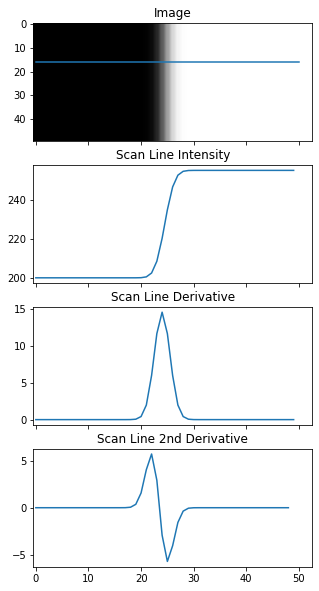

In [24]:
image = np.tile(np.repeat([200, 255], 32), (64, 1))
image = convolve(image, gaussian_filter(15, 1.5), pad=False, clip=False)

show_scanline(image, second_order=True)

Notice that when we use the 2nd order derivative, the edge corresponds to the "0 crossing", while using 1st order derivative, the edge corresponds to the extrema.
Thus, it localizes the edges better, but may be more inconvenient to use.

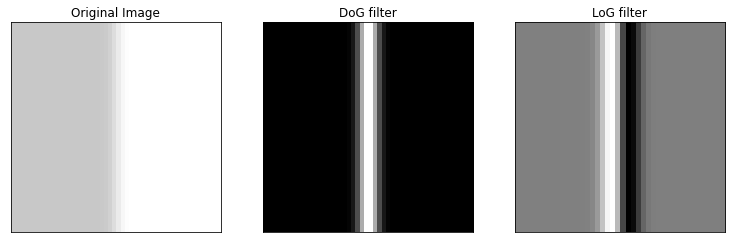

In [25]:
mag, _ = compute_gradient(image, gradient_kernel=make_dog)
log_result = convolve(image, log(11), clip=False, pad=False)

show_images([(image, "Original Image"), 
             (mag, "DoG filter", True),
            (log_result, "LoG filter", True)])

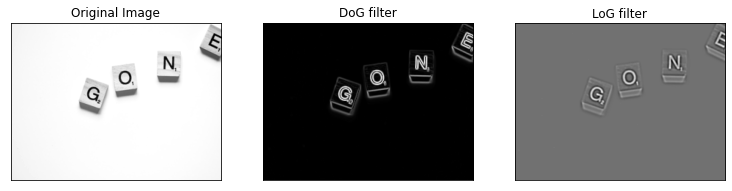

In [26]:
mag, _ = compute_gradient(words_image, gradient_kernel=make_dog)
log_result = convolve(words_image, log(11), clip=False, pad=False)

show_images([(words_image, "Original Image"), 
             (mag, "DoG filter", True),
            (log_result, "LoG filter", True)])

## Canny edge detection

### Thresholding
Once we obtain our magnitude plot, a naive way to obtain the edges is to simply pick all the pixels which exceed a certain threshold, as per below.

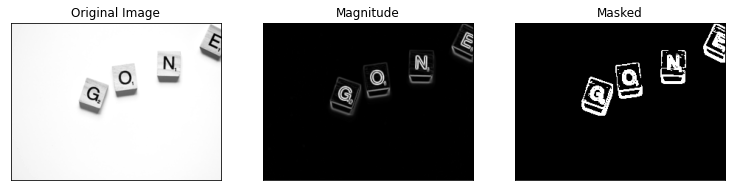

In [34]:
THRESHOLD = 15
mag, _ = compute_gradient(words_image, gradient_kernel=make_dog)
masked = np.where(mag > THRESHOLD, 255, 0)

show_images([(words_image, "Original Image"), 
             (mag, "Magnitude", True),
            (masked, "Masked", True)])

However, notice that with the given threshold value, we did not pick up all the edges (above the "N" tile), and picked up too many edges also (the edges of "E" tile is thick).
Hence, there will not be a singular threshold value that can give us a good result, because increasing it will increase our false negatives, while decreasing it will increase our false positives.

### Non-maximum suppression
To "thin down" the thick edges, we can apply **non-maximum suppression**.
For each pixel, we check if it is a local maximum along its gradient direction.
If so, we keep it (it is the highest magnitude within the thick edge), else we discard it (there is another pixel which has a higher magnitude that can represent the thick edge).

Suppose that our gradient points us to a location that is sub-pixel (*ie* the location pointed in the gradient direction is between 2 pixels).
Then we can either take the closest pixel value, or we can use interpolated pixel magnitude between the 2 pixel values.

In [28]:
from module.canny_edge import nonmaximum_suppression

show_implementation(nonmaximum_suppression)

def nonmaximum_suppression(mag, theta, interpolate=True):
    octant = np.floor((theta + np.pi * 2) / (np.pi / 4)) % 8
    excess = (theta + np.pi * 2) - octant * (np.pi/4)
    excess = np.where(excess >= np.pi * 2, excess - np.pi * 2, excess)
    excess_ratio = excess / (np.pi / 4)

    octant_map = {0: (0,  1), 1: ( 1, 1),  2: ( 1, 0), 3: (1, -1), 
                  4: (0, -1), 5: (-1, -1), 6: (-1, 0), 7: (-1, 1)}
    
    result = np.zeros(mag.shape, dtype=np.uint8)
    
    height, width = mag.shape
    
    for i in range(1, height - 1):
        for j in range(1, width -1):
            pixel_val = mag[i][j]
            
            main_dir = octant_map[octant[i][j]]
            next_dir = octant_map[(octant[i][j] + 1) % 8]
            main_mag = mag[i + main_dir[0]][j + main_dir[1]]
            next_mag = mag[i + next_dir[0]][j + next_dir[1]]
            
            if interpolate:
                target_mag = excess_ratio[i][j] * next_mag + (1-excess_ratio[i][j]) * main_mag
   

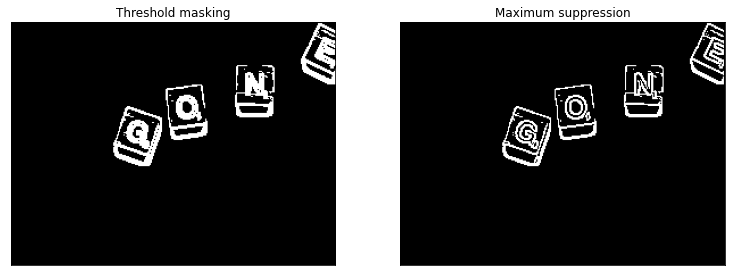

In [29]:
THRESHOLD = 15
mag, theta = compute_gradient(words_image, gradient_kernel=make_dog)

thresholded = np.where(mag >= THRESHOLD, mag, 0)
nonmaximum_suppressed = nonmaximum_suppression(thresholded, theta)

masked = np.where(mag >= THRESHOLD, 1, 0)

show_images([(masked, "Threshold masking", True),
            (nonmaximum_suppressed, "Maximum suppression", True)])

By using non-maximum suppression, we reduced the "thickness" of the edges detected, thus giving us a cleaner result.

Note that we still cannot simply reduce the threshold to fix the issue of not picking up the edges above the "N" tile, because right now, the system is picking up quite a bit of noise (within the "G" and "N" tiles).
Thus, reducing the threshold will introduce more noise.

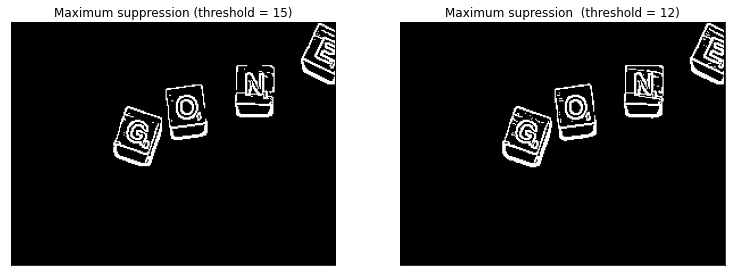

In [30]:
THRESHOLD = 15
mag, theta = compute_gradient(words_image, gradient_kernel=make_dog)

thresholded = np.where(mag >= 12, mag, 0)
lower_threshold = nonmaximum_suppression(thresholded, theta)

show_images([(nonmaximum_suppressed, "Maximum suppression (threshold = 15)", True),
            (lower_threshold, "Maximum supression  (threshold = 12)", True)])

Indeed, finding a threshold where the edge of the "N" tile is fully picked up causes more noise within the tiles.
However, it does clue us in to use information from the two thresholded images.

### Hysteresis thresholding
The concept is simple:
1. Find all pixels $H$ that clears the high threshold
2. Find all pixels $L$ that clears the low threshold
3. Add all pixels in $H$ into our desired result $R$
4. Add pixels in $L$ into our desired result only if they are spatially close to some pixel in $R$

The idea behind it is that we start with "strong edges".
Then we extend these edges by "weak edges" to complete our edge detection.

In [31]:
from module.canny_edge import hysteresis_threshold

show_implementation(hysteresis_threshold)

def hysteresis_threshold(high_pixels, low_pixels):
    assert high_pixels.shape == low_pixels.shape
    
    result = np.zeros(high_pixels.shape)
    
    height, width = high_pixels.shape
    
    def neighbours(i, j):
        arr = [(i-1, j-1), (i-1, j), (i-1, j+1),
               (i, j-1), (i, j), (i, j+1),
               (i+1, j-1), (i+1, j), (i+1, j+1),
              ]
        
        arr = tuple(filter(lambda e: e[0] >= 0 and e[0] < height and e[1] >= 0 and e[1] < width, arr))
        
        return arr
    
    start_indices = tuple(zip(*high_pixels.nonzero()))
    
    def dfs(i, j):
        result[i][j] = 1
        
        for i_p, j_p in neighbours(i, j):
            if not result[i_p][j_p] and low_pixels[i_p][j_p]:
                dfs(i_p, j_p)
    
    for index in start_indices:
        dfs(*index)
    
    return result


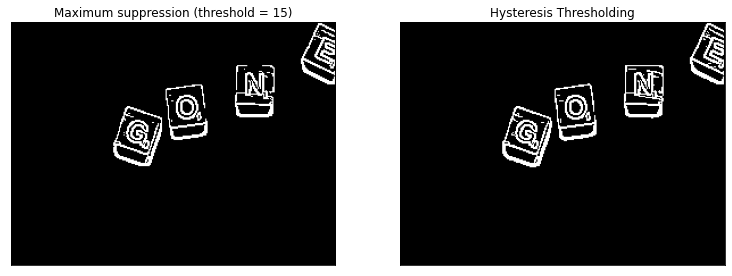

In [36]:
hyteresis_thresholded = hysteresis_threshold(nonmaximum_suppressed, lower_threshold)

show_images([(nonmaximum_suppressed, "Maximum suppression (threshold = 15)", True),
            (hyteresis_thresholded, "Hysteresis Thresholding", True)])

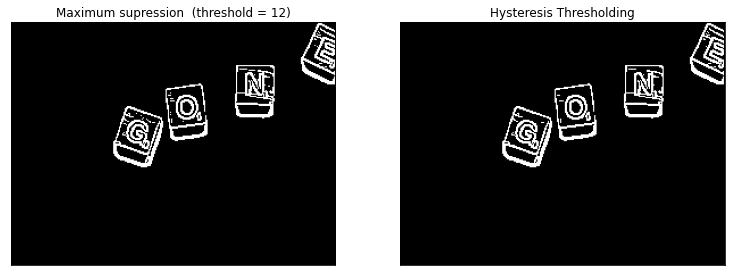

In [37]:
hyteresis_thresholded = hysteresis_threshold(nonmaximum_suppressed, lower_threshold)

show_images([(lower_threshold, "Maximum supression  (threshold = 12)", True),
            (hyteresis_thresholded, "Hysteresis Thresholding", True)])

As we can see, our result picks up the edge of the "N" tile fully, while having less noisy compared to using a lower threshold.

Hence, the implementation of the canny edge detector (as demonstrated at the start of this chapter), is as follows:

In [38]:
show_implementation(canny_edge)

def canny_edge(image, high_threshold, low_threshold, kernel_size=5):    
    make_dog = lambda orientation: dog(kernel_size, orientation=orientation)

    mag, theta = compute_gradient(image, gradient_kernel=make_dog)
    
    high_pixels = nonmaximum_suppression(np.where(mag >= high_threshold, mag, 0), theta)
    low_pixels = nonmaximum_suppression(np.where(mag >= low_threshold, mag, 0), theta)

    result = hysteresis_threshold(high_pixels, low_pixels)
    return result


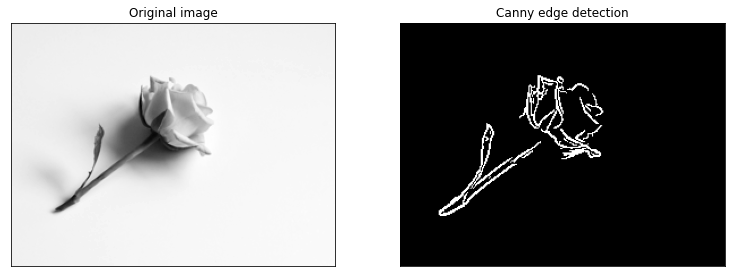

In [40]:
show_images([(rose_image, "Original image", True),
            (canny_edge(rose_image, 25, 18), "Canny edge detection", True)])